# Pretraining an OLMo model with PyTorch FSDP

This tutorial demonstrates how to pretrain a small OLMo model using PyTorch Fully Sharded Data Parallel (FSDP) technology on AMD Instinct™ GPUs. OLMo is an open-source repository developed by AI2 for training and utilizing state-of-the-art open language models. AMD researchers have leveraged this repository to train their first small language model, showcased on Hugging Face: [AMD-OLMo](https://huggingface.co/collections/amd/amd-olmo-6723e7d04a49116d8ec95070).

Training AI models at scale poses significant challenges, particularly with limited compute and system resources. PyTorch FSDP is one of the frameworks designed to address these challenges by enabling efficient distributed training. This tutorial provides a step-by-step guide for setting up and running a small-scale OLMo pretraining task using FSDP.

For more information on PyTorch FSDP, see the [PyTorch documentation](https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html).

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

- **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

- **AMD Instinct GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

- **ROCm 6.2**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

   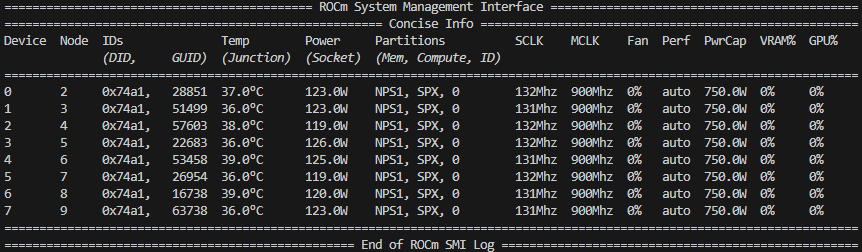


- **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

## Setting up the training environment:

### 1. Pull the Docker image

Use the following command to download the latest PyTorch Docker image optimized for AMD GPUs:

``` bash
docker pull rocm/pytorch:latest
```

### 2. Launch the Docker container

Run the following command to create and start a Docker container with the necessary configuration:

``` bash
docker run -it --rm \
  --device /dev/dri \
  --device /dev/kfd \
  --network host \
  --ipc host \
  --group-add video \
  --cap-add SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --privileged \
  --name megatron-dev-env \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  rocm/pytorch:latest \
  /bin/bash
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).

### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure that port `8888` is not already in use on your system before running the above command. If it is, specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

### 4. Install the required libraries

Inside the Jupyter environment, install any missing dependencies:


In [ ]:
%%bash

git clone https://github.com/allenai/OLMo.git

cd OLMo

pip install -e .

pip install wandb datasets torchmetrics numpy==1.22.4

## Dataset preparation

This tutorial uses the WikiText-103 dataset, a popular benchmark for language model training. Download and prepare the dataset using the following commands:

In [ ]:
# download dataset 
%cd OLMo
!wget https://olmo-data.org/preprocessed/olmo-mix/v1_5/gpt-neox-20b-pii-special/part-000-00001.npy

## Training the model

Use the following script to launch training for a small OLMo model. This script configures the model, tokenizer, and training loop with PyTorch FSDP:

In [ ]:
# start training
# configuration is saved in configs/official-0724/OLMo-1B.yaml, where you can modify training parameters,
# i.e. max_duration, batch size, learning range, etc. 
!WANDB_MODE=dryrun WANDB_DISABLED=true torchrun --nproc_per_node=8 --master_port=12345 scripts/train.py configs/official-0724/OLMo-1B.yaml \
--data.paths=["part-000-00001.npy"] --save_folder="output" --global_train_batch_size=128 --save_overwrite

### Monitoring the training progress

During training, you can see logs indicating the loss values and checkpoint saves. Here is an example log:

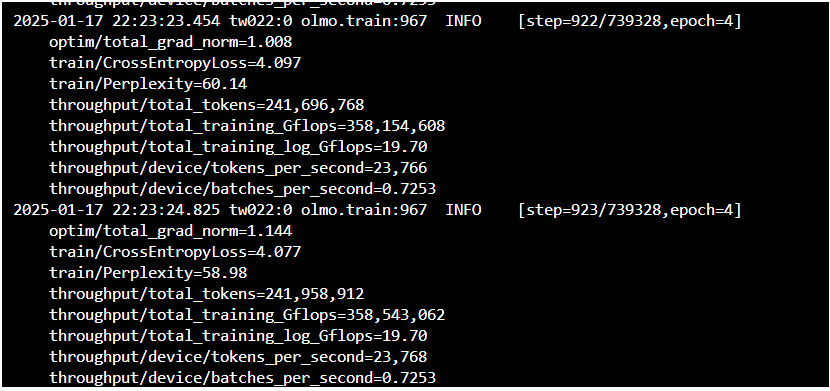

Checkpoints are saved periodically based on the `save_interval` parameter. After training, these checkpoints can be used to evaluate the performance of the model.

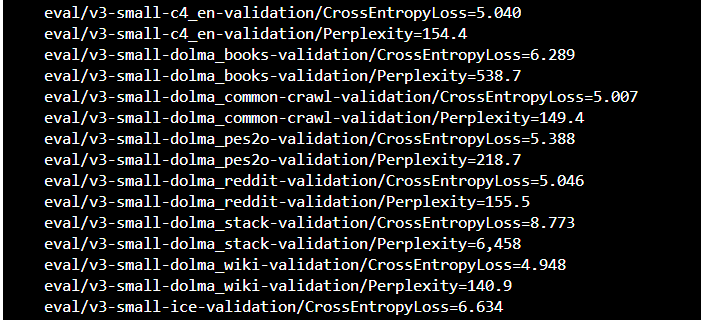

## Evaluating and testing the trained model

After completing the training process, the next step is to evaluate and test the newly trained model to ensure it meets your expectations. Follow the steps below to get started.

### Import the required libraries

Before proceeding, import all the libraries necessary to initialize and test the trained model:

In [25]:
from olmo.model import OLMo
import sys
from olmo import Tokenizer, TrainConfig
from typing import Optional
import torch
from olmo import OLMo, Tokenizer, TrainConfig
from olmo.config import ModelConfig, PaddingDirection
from olmo.data import DataCollator

### Build the text generation class

Create a Python class for the model’s text generation capabilities.

In [ ]:
class TextGenerator:
    def __init__(self, config_path: str, checkpoint_dir: str, model_path: str, use_amp: bool = True):
        self.config_path = config_path
        self.checkpoint_dir = checkpoint_dir
        self.model_path = model_path
        self.use_amp = use_amp
        
        self.cfg = self._load_config()
        self.tokenizer = self._load_tokenizer()
        self.device = self._set_device()
        self.model = self._initialize_model()
    
    def _load_config(self) -> TrainConfig:
        """Loads the configuration from the YAML file."""
        return TrainConfig.load(self.config_path, ['save_folder=output'])
    
    def _load_tokenizer(self) -> Tokenizer:
        """Loads the tokenizer from the checkpoint directory."""
        return Tokenizer.from_checkpoint(self.checkpoint_dir)
    
    def _set_device(self) -> torch.device:
        """Sets the device to CUDA if available, otherwise CPU."""
        cuda = torch.cuda.is_available()
        return torch.device("cuda" if cuda else "cpu")
    
    def _initialize_model(self) -> OLMo:
        """Initializes and loads the model weights."""
        self.cfg.data.pad_direction = PaddingDirection.left  # Ensure padding is left during generation
        self.cfg.model.init_device = self.device
        model = OLMo(self.cfg.model)
        model.load_state_dict(torch.load(self.model_path, weights_only=True), strict=False)
        return model
    
    def generate_text(self, input_text: str) -> str:
        """Generates text based on the input text."""
        tokens = self.tokenizer.encode(input_text, add_special_tokens=False)
        beam_search_kwargs = dict(beam_size=1, max_steps=30)

        with torch.inference_mode():
            with torch.autocast(device_type=self.device.type, enabled=self.use_amp):
                output_token_ids = self.model.generate(
                    torch.tensor(tokens, device=self.device).unsqueeze(0),
                    **beam_search_kwargs,
                ).token_ids
                
                if isinstance(output_token_ids, torch.Tensor):
                    output_token_ids = output_token_ids.cpu()
                if not isinstance(output_token_ids, list):
                    output_token_ids = output_token_ids.tolist()

                decoded_outputs = self._decode_output(output_token_ids)
                return decoded_outputs

    def _decode_output(self, output_token_ids: list) -> str:
        """Decodes the generated output tokens back into text."""
        decoded_outputs = []
        for sequences in output_token_ids:
            for sequence in sequences:
                if self.tokenizer.pad_token_id in sequence:
                    sequence = sequence[:sequence.index(self.tokenizer.pad_token_id)]
                decoded_text = self.tokenizer.decode(sequence, skip_special_tokens=True)
                decoded_outputs.append(decoded_text)
        return " ".join(decoded_outputs)



### Load the trained weights and initialize the model

Load the trained weights into the model to enable inference using the pre-trained parameters.

In [120]:
config_path = "OLMo/configs/official-0724/OLMo-1B.yaml"
checkpoint_dir = "OLMo/output/step100-unsharded"
model_path = "OLMo/output/step100-unsharded/model.pt"
text_generator = TextGenerator(config_path, checkpoint_dir, model_path)

### Test the model

Test the model’s performance by generating text outputs based on the input prompts.

In [ ]:
while True:
        user_input = input("Enter some text: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Exiting ...")
            break
        response = text_generator.generate_text(user_input)
        print(f"Bot: {response}")
        print("*******************************************")
